In [1]:
import sys
sys.path.append('..')

import quarantines as Q
import quarantines_mongo as qm 
import graph_generators as gg
import networkx as nx 
import matplotlib.pyplot as plt 
import seaborn as sns
import numpy as np
import utils
sns.set()

In [2]:
N = 10 ** 4
G = gg.ba_graph(N, 10)

In [3]:
# Need to do a smoothing on this: 
# Plots will require some binning... 
# Clever binning strategy -- group by y-val and then find average x-val to fit
# Actually want to do vertical binning 
def get_group_prop_smooth(G, tau, gamma, num_init, num_iter, k):
    # Returns smoothed [(total_prop, mean, std)...] of this for topk
    output_getter = lambda : get_topk_vs_prop(G, tau, gamma, num_init, k)
    if k == 'min':
        output_getter = lambda : get_mindeg(G, tau, gamma, num_init)
    outputs = [output_getter() for _ in range(num_iter)]
    return smooth_group_vertically(outputs)


    
def get_topk_vs_prop(G, tau, gamma, num_init, k):
    """Takes a summary structure and returns a list of pairs of the form 
         [(#I+R, #topk), ...] where each pair is 
         p0: the number of I+R nodes infected when the i^th node in the topk% gets infected 
    """
    summary = Q.quarantine_by_prop(G, tau, gamma, num_init/len(G), [0], float('inf'), return_summary=True)[1][0]
    sorted_deg = sorted(dict(G.degree()).items(), key=lambda p: -p[1])
    topk = set([_[0] for _ in sorted_deg[:int(len(G) * k ) + 1]])
    
    output = [] 
    num_topk = 0
    for idx, xmission in enumerate(summary.transmissions()):
        if xmission[-1] in topk:
            num_topk += 1
            output.append((idx / len(G), num_topk / len(topk)))
    return output



def get_mindeg(G, tau, gamma, num_init):
    """Takes a summary structure and returns a list of pairs of the form 
         [(#I+R, #topk), ...] where each pair is 
         p0: the number of I+R nodes infected when the i^th node in the topk% gets infected 
    """
    summary = Q.quarantine_by_prop(G, tau, gamma, num_init/len(G), [0], float('inf'), return_summary=True)[1][0]
    sorted_deg = sorted(dict(G.degree()).items(), key=lambda p: -p[1])
    mindeg = max([1, min(sorted_deg, key=lambda p: p[1])[1]])
    deg1 = set([_[0] for _ in dict(G.degree()).items() if _[1] == mindeg])
    
    output = [] 
    num_deg1 = 0
    for idx, xmission in enumerate(summary.transmissions()):
        if xmission[-1] in deg1:
            num_deg1 += 1
            output.append((idx / len(G), num_deg1 / len(deg1)))
    return output


def smooth_group_vertically(output_list):
    # Do linear interpolation along x's 
    xrefs = [_[0] for _ in output_list[0]]
    yvals = [[_[1] for _ in output_list[1]]]
    
    for output in output_list[1:]:
        yval = []
        idx = 0
        for xref in xrefs:
            while idx < (len(output) -2) and output[idx + 1][0] < xref:
                idx += 1
            delta_y = output[idx + 1][1] - output[idx][1]
            delta_x = output[idx + 1][0] - output[idx][0] 
            yval.append(min([1.0, output[idx][1] + (xref - output[idx][0]) / delta_x * delta_y]))
        yvals.append(yval)
    # And then interp to (x, meany, std)
    means = [np.mean(_) for _ in zip(*yvals)]
    stds = [np.std(_) for _ in zip(*yvals)]
    if len(xrefs) > len(means):
        xrefs = xrefs[:len(means)]
    return np.array(xrefs), np.array(means), np.array(stds)

    
def plot_trip(xs, means, stds, c, label=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    # Plots with triples 
    ax.plot(xs, means, c=c, label=label)
    ax.fill_between(xs, means -stds, means + stds, color=c, alpha=0.5)
    return ax

def label_getter(k):
    if k == 'min':
        return 'Min Degree'
    return 'Top %s' % int(k * 100) + '%'


def plot_fulls(G, tau, gamma, num_init, num_iter, klist):
    
    data = {k: get_group_prop_smooth(G, tau, gamma, num_init, num_iter, k) for k in klist}
    fig, ax = plt.subplots(figsize=(10, 10))
    for i, k in enumerate(data.keys()):
        xs, means, stds = data[k] 
        ax = plot_trip(xs, means, stds, utils.c(i), label=label_getter(k), ax=ax)
    return fig, ax

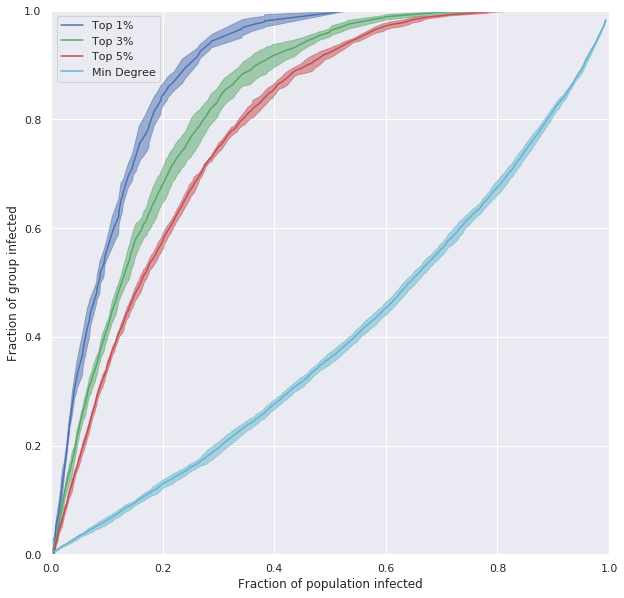

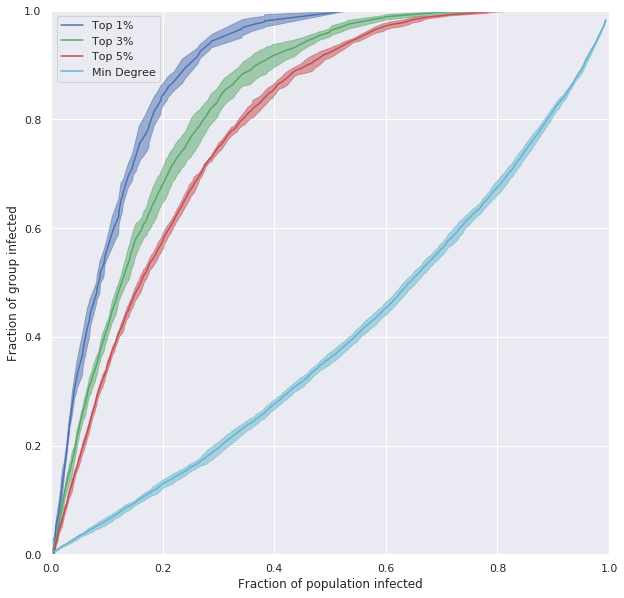

In [4]:
G = gg.ba_graph(10 ** 4, 10)
fig, ax = plot_fulls(G, 0.5, 1.0, 50, 5, [0.01, 0.03, 0.05, 'min'])
ax.set_xlabel("Fraction of population infected")
ax.set_ylabel("Fraction of group infected")
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.legend()
fig


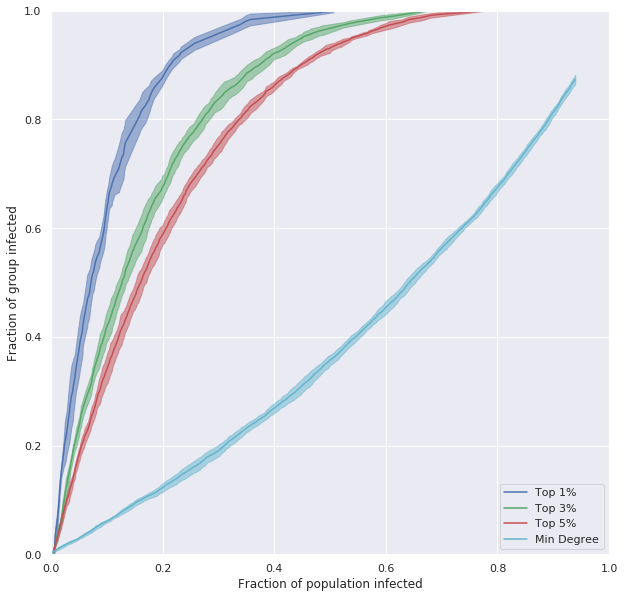

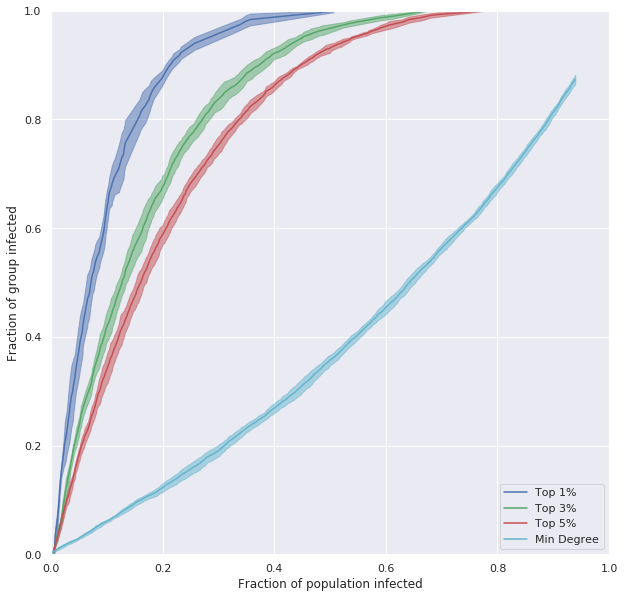

In [5]:
G = gg.ba_graph(10 ** 4, 10)
fig, ax = plot_fulls(G, 0.25, 1.0, 50, 5, [0.01, 0.03, 0.05, 'min'])
ax.set_xlabel("Fraction of population infected")
ax.set_ylabel("Fraction of group infected")
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.legend()
fig


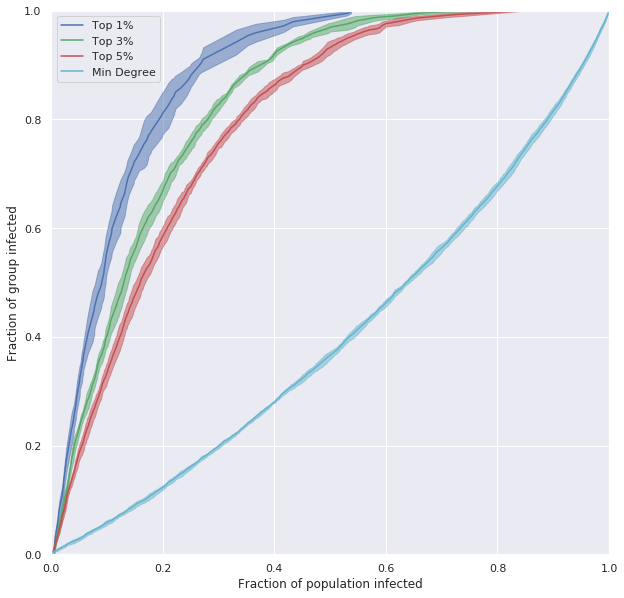

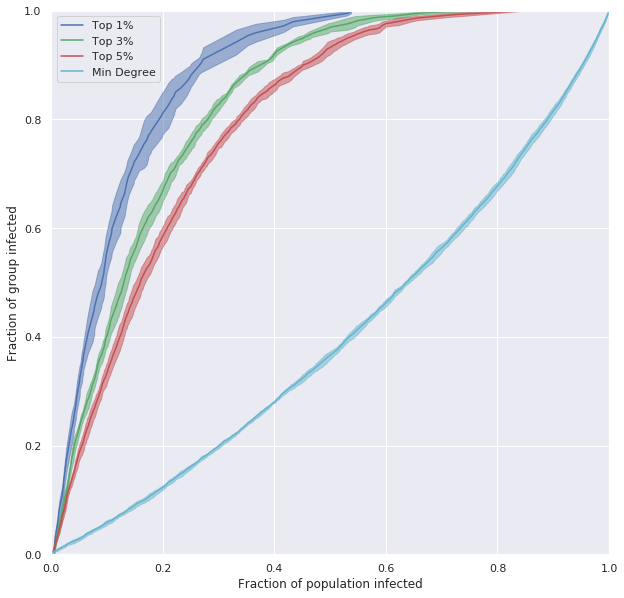

In [6]:
G = gg.ba_graph(10 ** 4, 10)
fig, ax = plot_fulls(G, 2.0, 1.0, 50, 5, [0.01, 0.03, 0.05, 'min'])
ax.set_xlabel("Fraction of population infected")
ax.set_ylabel("Fraction of group infected")
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.legend()
fig


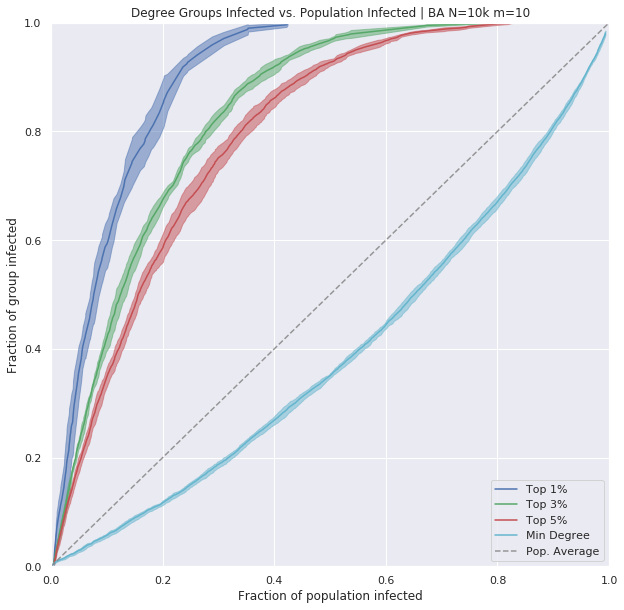

In [79]:
ax.set_title("Degree Groups Infected vs. Population Infected | BA N=10k m=10")
fig

In [81]:
fb_artist = gg.load_gemsec_fb('artist')

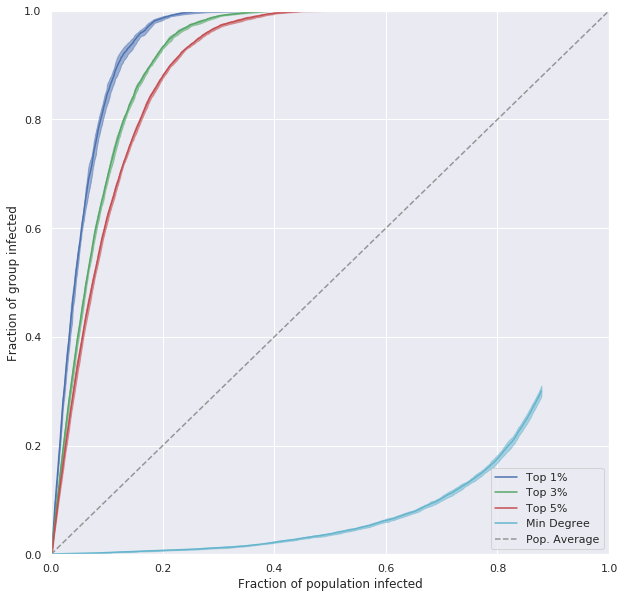

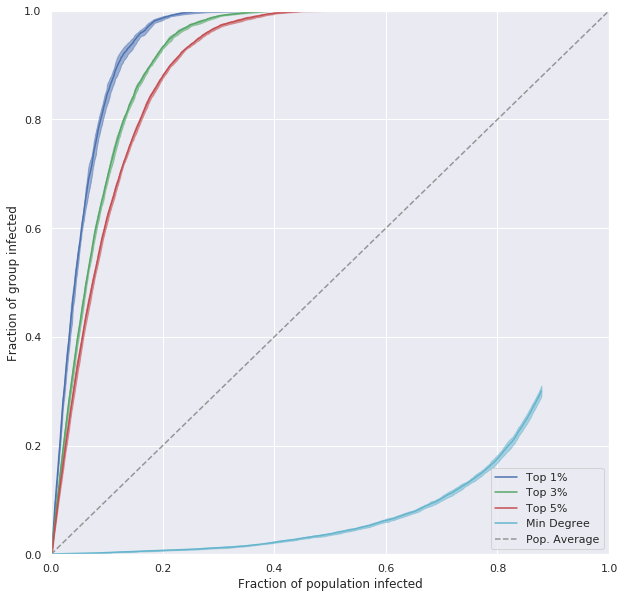

In [83]:
fig, ax = plot_fulls(fb_artist, 0.5, 1.0, 50, 5, [0.01, 0.03, 0.05, 'min'])
ax.plot([0.0, 1.0], [0.0, 1.0], linestyle='dashed', alpha=0.8, c='grey', label='Pop. Average')
ax.set_xlabel("Fraction of population infected")
ax.set_ylabel("Fraction of group infected")
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)
ax.legend()
fig

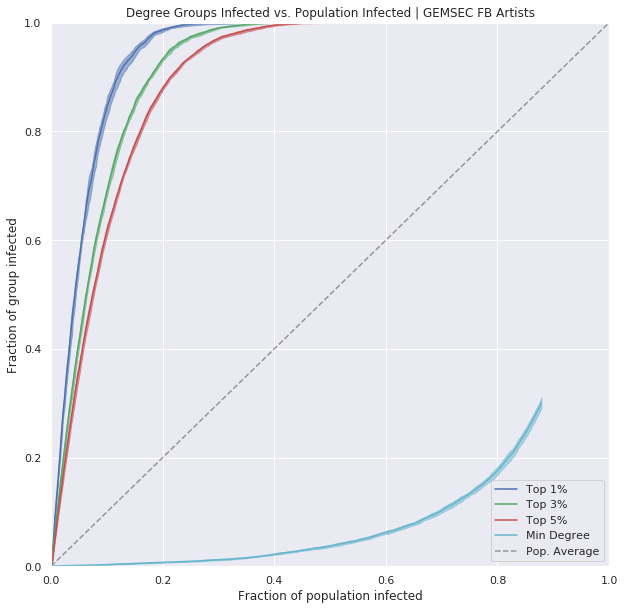

In [84]:
ax.set_title("Degree Groups Infected vs. Population Infected | GEMSEC FB Artists")
fig

In [ ]:
summ= Q.quarantine_by_prop(G, 1, 1, 10 / N, [0.0], float('inf'), return_summary=True)[1]

In [ ]:
summ[0].transmissions()

In [ ]:
sorted(dict(G.degree()).items(), key=lambda p: -p[1])

In [ ]:
def get_topk_vs_prop(G, summary, k):
    """Takes a summary structure and returns a list of pairs of the form 
         [(#I+R, #topk), ...] where each pair is 
         p0: the number of I+R nodes infected when the i^th node in the topk% gets infected 
    """
    sorted_deg = sorted(dict(G.degree()).items(), key=lambda p: -p[1])
    topk = set([_[0] for _ in sorted_deg[:int(len(G) * k ) + 1]])
    
    output = [] 
    num_topk = 0
    for idx, xmission in enumerate(summary.transmissions()):
        if xmission[-1] in topk:
            num_topk += 1
            output.append((idx / len(G), num_topk / len(topk)))
    return output

def get_mindeg(G, summary):
    """Takes a summary structure and returns a list of pairs of the form 
         [(#I+R, #topk), ...] where each pair is 
         p0: the number of I+R nodes infected when the i^th node in the topk% gets infected 
    """
    sorted_deg = sorted(dict(G.degree()).items(), key=lambda p: -p[1])
    mindeg = max([1, min(sorted_deg, key=lambda p: p[1])[1]])
    deg1 = set([_[0] for _ in dict(G.degree()).items() if _[1] == ])
    
    output = [] 
    num_deg1 = 0
    for idx, xmission in enumerate(summary.transmissions()):
        if xmission[-1] in deg1:
            num_deg1 += 1
            output.append((idx / len(G), num_deg1 / len(deg1)))
    return output


In [14]:
utils.c(1)

'g'

In [ ]:
len(summ[0].transmissions())

In [ ]:
def plot_degs(G, tau, gamma, num_init):
    summ = Q.quarantine_by_prop(G, tau, gamma, num_init / len(G), [0.0], float('inf'), return_summary=True)[1]
    fig, ax = plt.subplots(figsize=(10,10))
    top1 = get_topk_vs_prop(G, summ[0], 0.01)
    top3 = get_topk_vs_prop(G, summ[0], 0.03)
    top5 = get_topk_vs_prop(G, summ[0], 0.05)
    top10 = get_topk_vs_prop(G, summ[0], 0.10)
    deg1 = get_mindeg(G, summ[0])
    ax.plot(*zip(*top1), c='r', label='top1%')
    ax.plot(*zip(*top3), c='b', label='top3%')
    ax.plot(*zip(*top5), c='g', label='top5%')
    ax.plot(*zip(*top10), c='k', label='top10%')
    ax.plot([0.0, 1.0], [0.0,1.0], label='y=x reference')
    ax.plot(*zip(*deg1), label='MinDegree')
    ax.legend()

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
top1 = get_topk_vs_prop(G, summ[0], 0.01)
top3 = get_topk_vs_prop(G, summ[0], 0.03)
top5 = get_topk_vs_prop(G, summ[0], 0.05)
top10 = get_topk_vs_prop(G, summ[0], 0.10)
deg1 = get_mindeg(G, summ[0])
ax.plot(*zip(*top1), c='r', label='top1%')
ax.plot(*zip(*top3), c='b', label='top3%')
ax.plot(*zip(*top5), c='g', label='top5%')
ax.plot(*zip(*top10), c='k', label='top10%')
ax.plot([0.0, 1.0], [0.0,1.0], label='y=x reference')
ax.plot(*zip(*deg1), label='MinDegree')
ax.legend()

In [ ]:
plot_degs(G, 1,1, 10)

In [ ]:
fb_artist = gg.load_gemsec_fb('artist')
plot_degs(fb_artist, 1, 1, 10)

In [ ]:
# Need to do a smoothing on this: 
# Plots will require some binning... 
# Clever binning strategy -- group by y-val and then find average x-val to fit
# Actually want to do vertical binning 
def get_group_prop_smooth(G, tau, gamma, num_init, num_iter, k):
    # Returns smoothed [(total_prop, mean, std)...] of this for topk
    output_getter = lambda : get_topk_vs_prop(G, tau, gamma, num_init, k)
    if k == 'min':
        output_getter = lambda : get_mindeg(G, tau, gamma, num_init)
    outputs = [output_getter() for _ in range(num_iter)]
    return smooth_group_vertically(outputs)


    
def get_topk_vs_prop(G, tau, gamma, num_init, k):
    """Takes a summary structure and returns a list of pairs of the form 
         [(#I+R, #topk), ...] where each pair is 
         p0: the number of I+R nodes infected when the i^th node in the topk% gets infected 
    """
    summary = Q.quarantine_by_prop(G, tau, gamma, num_init/len(G), [0], float('inf'), return_summary=True)[1][0]
    sorted_deg = sorted(dict(G.degree()).items(), key=lambda p: -p[1])
    topk = set([_[0] for _ in sorted_deg[:int(len(G) * k ) + 1]])
    
    output = [] 
    num_topk = 0
    for idx, xmission in enumerate(summary.transmissions()):
        if xmission[-1] in topk:
            num_topk += 1
            output.append((idx / len(G), num_topk / len(topk)))
    return output



def get_mindeg(G, tau, gamma, num_init):
    """Takes a summary structure and returns a list of pairs of the form 
         [(#I+R, #topk), ...] where each pair is 
         p0: the number of I+R nodes infected when the i^th node in the topk% gets infected 
    """
    summary = Q.quarantine_by_prop(G, tau, gamma, num_init/len(G), [0], float('inf'), return_summary=True)[1][0]
    sorted_deg = sorted(dict(G.degree()).items(), key=lambda p: -p[1])
    mindeg = max([1, min(sorted_deg, key=lambda p: p[1])[1]])
    deg1 = set([_[0] for _ in dict(G.degree()).items() if _[1] == mindeg])
    
    output = [] 
    num_deg1 = 0
    for idx, xmission in enumerate(summary.transmissions()):
        if xmission[-1] in deg1:
            num_deg1 += 1
            output.append((idx / len(G), num_deg1 / len(deg1)))
    return output


def smooth_group_vertically(output_list):
    # Do linear interpolation along x's 
    xrefs = [_[0] for _ in output_list[0]]
    yvals = [[_[1] for _ in output_list[1]]]
    
    for output in output_list[1:]:
        yval = []
        idx = 0
        for xref in xrefs:
            while idx < (len(output) -2) and output[idx + 1][0] < xref:
                idx += 1
            delta_y = output[idx + 1][1] - output[idx][1]
            delta_x = output[idx + 1][0] - output[idx][0] 
            yval.append(min([1.0, output[idx][1] + (xref - output[idx][0]) / delta_x * delta_y]))
        yvals.append(yval)
    # And then interp to (x, meany, std)
    means = [np.mean(_) for _ in zip(*yvals)]
    stds = [np.std(_) for _ in zip(*yvals)]
    return np.array(xrefs), np.array(means), np.array(stds)

    
def plot_trip(xs, means, stds, c, label=None, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 10))
    # Plots with triples 
    ax.plot(xs, means, c=c, label=label)
    ax.fill_between(xs, means -stds, means + stds, color=c, alpha=0.5)
    return ax

In [ ]:
xs, ys, stds = get_group_prop_smooth(G, 1, 1, 10, 5, 0.05)

In [ ]:
ax = plot_trip(xs, ys, stds, 'r', 'top5')
ax.legend()

In [ ]:
outputs = [get_topk_vs_prop(G, 1, 1, 10, 0.01) for _ in range(100)]

In [ ]:
xs, means, stds = smooth_group_vertically(outputs)

In [ ]:
plt.fill_between(xs, np.array(means) - np.array(stds), np.array(means) + np.array(stds), alpha=0.3)
plt.plot(xs, np.array(means))

In [ ]:
ys2 = ys[:50]

In [ ]:
plt.plot(xs, [np.mean(_) for _ in zip(*ys2)])

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
for y in ys:
    ax.plot(xs, y)
ax.plot([0.0, 1.0], [0.0,1.0])
ax.set_xlim(0.0, 1.0)
ax.set_ylim(0.0, 1.0)

In [ ]:
ys[0]

In [ ]:
outputs[1][:5]

In [ ]:
plt.plot(*zip(*[(_[0], _[1]) for _ in plottable]))

In [ ]:
plt.plot(*zip(*outputs[0]))